In [1]:
from typing import Annotated
from langchain_experimental.tools import PythonREPLTool, PythonAstREPLTool
import pandas as pd
import statsmodels as sm

# df = pd.read_csv("HOUST.csv")
df = pd.read_csv("USSTHPI.csv")
python_repl_tool = PythonAstREPLTool(locals={"df": df})

In [2]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate
import functools
import operator
from typing import Sequence, TypedDict

system_prompt = """You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
                It is important to understand the attributes of the dataframe before working with it. This is the result of running `df.head().to_markdown()`

                <df>
                {dhead}
                </df>

                You are not meant to use only these rows to answer questions - they are meant as a way of telling you about the shape and schema of the dataframe. 
                You also do not have use only the information here to answer questions - you can run intermediate queries to do exploratory data analysis to give you more information as needed. """
system_prompt = system_prompt.format(dhead=df.head().to_markdown())

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str # where to route to next

def create_agent(llm: ChatOpenAI, tools: list, task: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ( "system", system_prompt, ),
            HumanMessage(content=task),
            HumanMessage(content="The results from the analysis run so far are: "),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )

    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools) # verbose=True for debugging
    return executor

# AIMessage will have all kinds of metadata, bit of a hack to treat everything as HumanMessage
def agent_node(state: AgentState, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

def chain_node(state: AgentState, chain, name):
    result = chain.invoke(input={"detail": "medium", "messages": state["messages"]})
    return {"messages": [HumanMessage(content=result.content, name=name)]}

In [3]:
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", top_p=0.00001, seed=42424242) # trying to reduce randomness
llm_big = ChatOpenAI(model="gpt-4o", top_p=0.00001, seed=42424242)

eda_task = """Using the statsmodels package run an augmented dickey fuller test on the data.
            Then using the matplotlib package plot the time series, display it and save it to 'plot.png'.
            Next use the statsmodel package to generate an ACF plot with zero flag set to False, display it and save it to 'acf.png'.
            Then generate a PACF plot with zero flag set to False, display it and save it to 'pacf.png'"""
eda_agent = create_agent(llm, [python_repl_tool], task=eda_task,)
eda_node = functools.partial(agent_node, agent=eda_agent, name="EDA")

log_task = """Determine whether a log transformation is appropriate. 
                If it is then generate a new column for the log of the series and use the log data going forward."""
log_agent = create_agent(llm, [python_repl_tool], task=log_task, )
log_node = functools.partial(agent_node, agent=log_agent, name="Log")

difference_task = """Determine if a linear difference is needed and if needed generate a new column for the differenced data.
                    If a difference is needed use the statsmodel package to generate an ACF plot with zero flag set to False, display it and save it to 'acf_differenced.png'.
                    Finally generate a separate PACF plot with zero flag set to False, display it and save it to 'pacf_differenced.png'."""
diff_agent = create_agent(llm, [python_repl_tool], task=difference_task, )
diff_node = functools.partial(agent_node, agent=diff_agent, name="Difference")

In [4]:
plot_template = ChatPromptTemplate.from_messages(
    messages=[
        SystemMessage(content="""Determine whether this time series is stationary.
                      Consider the results of the ADF test along with the plot of the time series, the ACF plot and the PACF plot."""),
        MessagesPlaceholder(variable_name="messages"),
        HumanMessagePromptTemplate.from_template(
            template=[{"type": "image_url", "image_url": {"path": "plot.png"}},
                        {"type": "image_url", "image_url": {"path": "acf.png"}},
                        {"type": "image_url", "image_url": {"path": "pacf.png"}}]),
    ]
)

plot_chain = plot_template | llm_big
plot_node = functools.partial(chain_node, chain=plot_chain, name="PlotAnalysis")

diffplot_template = ChatPromptTemplate.from_messages(
    messages=[
        SystemMessage(content="""Determine if the differenced time series is stationary. 
                      Consider the results of the ADF test the ACF plot and the PACF plot."""),
        MessagesPlaceholder(variable_name="messages"),
        HumanMessagePromptTemplate.from_template(
            template=[{"type": "image_url", "image_url": {"path": "acf_differenced.png"}},
                        {"type": "image_url", "image_url": {"path": "pacf_differenced.png"}}]),
    ]
)

diffplot_chain = diffplot_template | llm_big
diffplot_node = functools.partial(chain_node, chain=diffplot_chain, name="DiffPlotAnalysis")

In [5]:
def router(state):
    router_template = ChatPromptTemplate.from_messages(
        messages=[
            MessagesPlaceholder(variable_name="messages"),
            HumanMessage("""If the time series is stationary, return true if it is not stationary return false. 
                         Just return true or false, nothing else.""")
        ]
    )

    router_chain = router_template | llm
    response = router_chain.invoke({"messages": state["messages"]})

    if response.content=="true":
        return "ARIMA"
    else:
        return "Log"

In [6]:
arima_task = """First consider the exploratory analysis and determine which dependent variable to model - either the original or the log transformed.
    If differencing was necessary to achieve stationarity use a d term for modeling, do not model the differenced data directly.
    Estimate a single ARIMA model for this dependent variable, using p, d, q terms based on the analysis up to this point.
    Display the model results.
    Then Generate an autocorrelation plot of the model residuals with the zero flag set to False, display it and saved it as 'resid_acf.png'
    Finally generate a partial autocorrelation plot of the model residuals with zero flag set to False, display it and save it as 'resid_pacf.png'"""

arima_task = """Based on the analysis so far determine which dependent variable to model - either the original or the log transformed.
    Estimate a single ARIMA model for this dependent variable, using appropriate values for the p, d, q terms.
    If differencing was necesary to achieve stationarity, do not apply a diff() before modeling - use the d term in the ARIMA command.
    Display the estimated model parameters.
    Then generate an autocorrelation plot of the model residuals with the zero flag set to False, display it and save it as 'resid_acf.png'
    Finally generate a partial autocorrelation plot of the model residuals with zero flag set to False, display it and save it as 'resid_pacf.png'"""

arima_agent = create_agent(llm, [python_repl_tool], task=arima_task,)
arima_node = functools.partial(agent_node, agent=arima_agent, name="ARIMA")

In [7]:
resid_template = ChatPromptTemplate.from_messages(
    messages=[
        SystemMessage(content="""The plots contain the autocorrelation and partial autocorrelation of residuals from an ARIMA model.
                      Based on the plot are any of the residual autocorrelations significant?
                      Should additional AR or MA terms be included in the model?"""),
        HumanMessagePromptTemplate.from_template(
            template=[{"type": "image_url", "image_url": {"path": "resid_acf.png"}}, 
                        {"type": "image_url", "image_url": {"path": "resid_pacf.png"}}]),
    ]
)

resid_chain = resid_template | llm_big
resid_node = functools.partial(chain_node, chain=resid_chain, name="Resid")

In [8]:
refit_task = """The previously estimated model can be improved by adding or removing AR and/or MA terms.
    Using the data in the dataframe `df` and the package statsmodels, estimate a new ARIMA model with a different number of AR and/or MA terms and display the estimated model.
    Then generate an autocorrelation and partial autocorrelation plot of the model residuals with zero flag set to False, display it and save it as 'refit_acf.png'"""

refit_agent = create_agent(llm, [python_repl_tool], task=refit_task,)
refit_node = functools.partial(agent_node, agent=refit_agent, name="ARIMA")

In [9]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)
workflow.add_node("EDA", eda_node)
workflow.add_node("PlotAnalysis", plot_node)
workflow.add_node("Log", log_node)
workflow.add_node("Difference", diff_node)
workflow.add_node("DiffPlotAnalysis", diffplot_node)
workflow.add_node("ARIMA", arima_node)
workflow.add_node("Resid", resid_node)
# workflow.add_node("Refit", refit_node)

workflow.add_edge(START, "EDA")
workflow.add_edge("EDA", "PlotAnalysis")
workflow.add_conditional_edges("PlotAnalysis", router)
workflow.add_edge("Log", "Difference")
workflow.add_edge("Difference", "DiffPlotAnalysis")
workflow.add_edge("DiffPlotAnalysis", "ARIMA")
workflow.add_edge("ARIMA", "Resid")
workflow.add_edge("Resid", END)
# workflow.add_edge("Resid", "Refit") # conditional edge to refit?
# workflow.add_edge("Refit", END)

graph = workflow.compile()

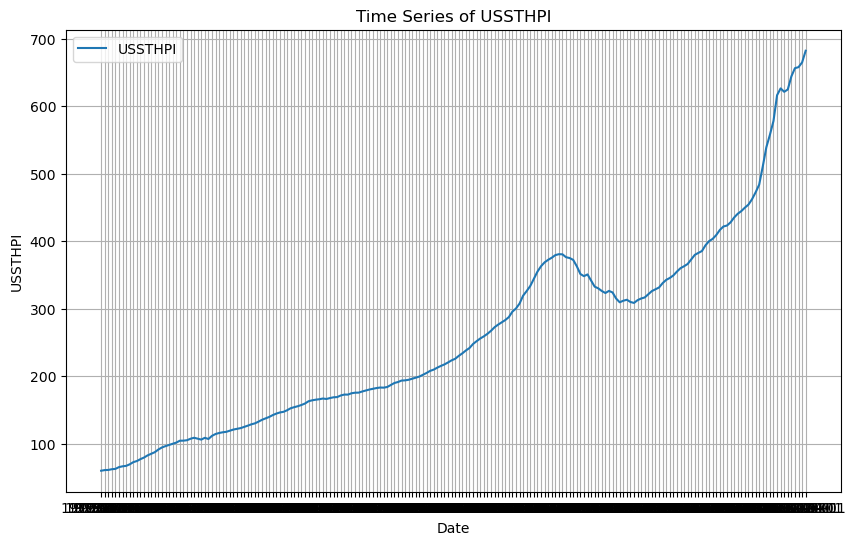

<Figure size 1000x600 with 0 Axes>

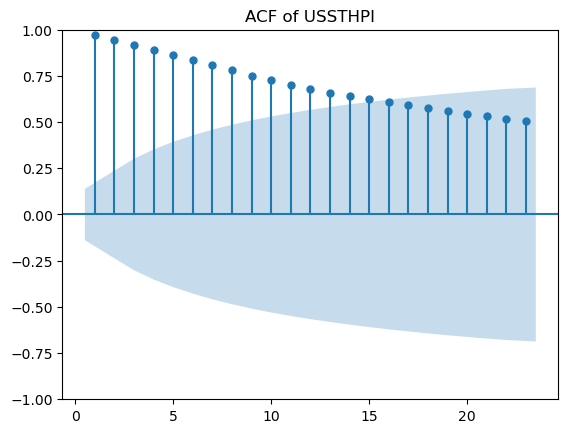

<Figure size 1000x600 with 0 Axes>

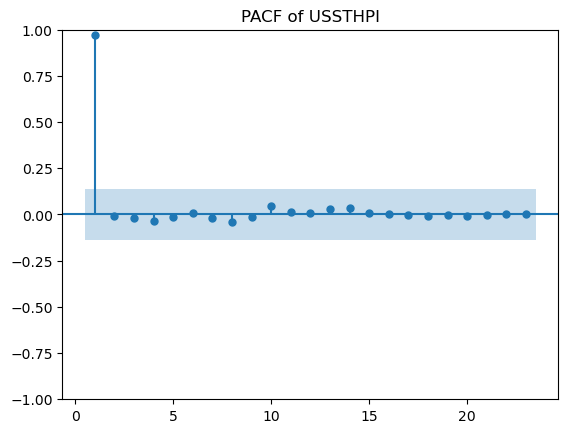

The analysis has been completed. Here are the results:

### Augmented Dickey-Fuller Test Results:
- **Test Statistic**: 1.584
- **p-value**: 0.998
- **Number of Lags Used**: 5
- **Number of Observations Used**: 192
- **Critical Values**:
  - 1%: -3.465
  - 5%: -2.877
  - 10%: -2.575
- **Maximized Information Criterion**: 947.664

### Plots Generated:
1. **Time Series Plot**: Saved as `plot.png`.
2. **ACF Plot**: Saved as `acf.png`.
3. **PACF Plot**: Saved as `pacf.png`.

If you need any further analysis or details, feel free to ask!
Based on the analysis:

### Augmented Dickey-Fuller Test
- **Test Statistic**: 1.584
- **p-value**: 0.998

The p-value is very high, indicating that we fail to reject the null hypothesis of the presence of a unit root. This suggests the time series is non-stationary.

### Time Series Plot
The plot shows an upward trend, further indicating non-stationarity.

### ACF and PACF Plots
- **ACF**: Shows a slow decay, which is typical of non-stationary series.
- **

<Figure size 1000x500 with 0 Axes>

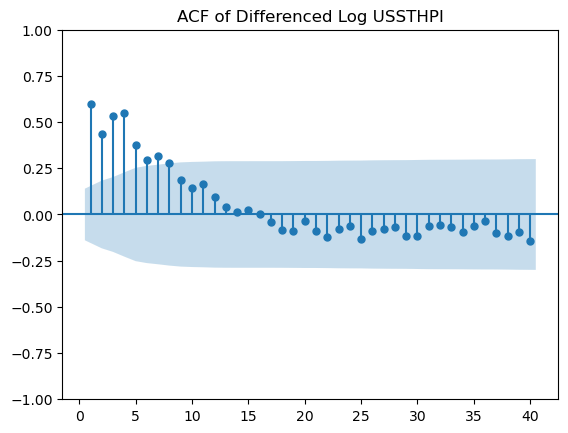

<Figure size 1000x500 with 0 Axes>

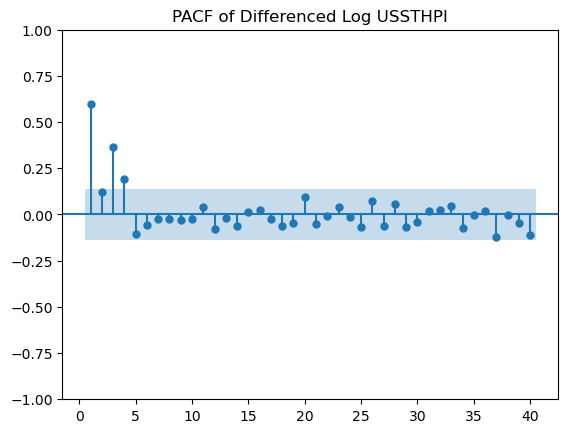

The analysis has been completed, and the following plots have been generated:

1. **ACF Plot**: Saved as `acf_differenced.png`.
2. **PACF Plot**: Saved as `pacf_differenced.png`.

These plots will help in understanding the autocorrelation and partial autocorrelation of the differenced log-transformed data. If you need further analysis or insights, please let me know!
### Analysis of Differenced Log-Transformed Data

#### ACF Plot
- The ACF plot shows a rapid decline, indicating that the differenced series is likely stationary.

#### PACF Plot
- The PACF plot has a significant spike at lag 1, suggesting an AR(1) process might be appropriate.

### Conclusion
The differenced log-transformed series appears to be stationary. You can proceed with modeling, possibly using an ARIMA model, considering the AR(1) process indicated by the PACF plot. If you need further assistance with model selection or fitting, let me know!


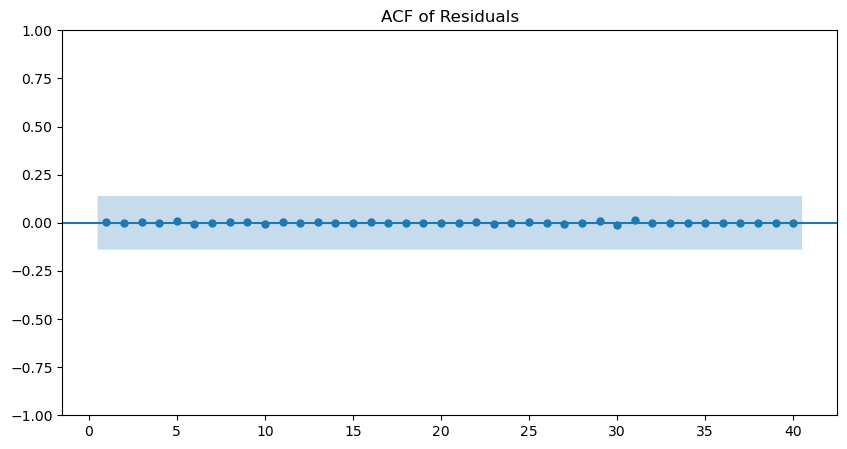

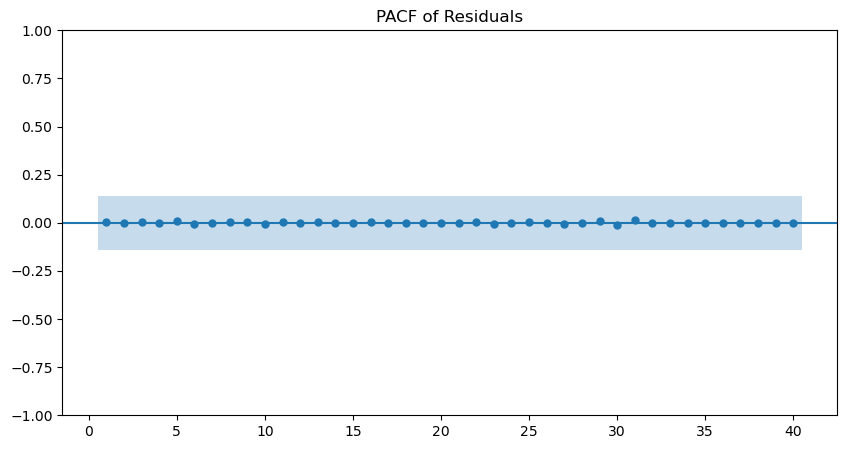

### ARIMA Model Results

The estimated ARIMA model parameters for the `Log_USSTHPI` series are as follows:

- **Model**: ARIMA(1, 1, 0)
- **Log Likelihood**: 597.511
- **AIC**: -1191.023
- **BIC**: -1184.457
- **HQIC**: -1188.365

#### Coefficients:
- **AR(1) Coefficient**: 0.7804 (p-value < 0.0001, indicating significance)
- **Variance of Residuals (sigma²)**: 0.0001 (p-value < 0.0001, indicating significance)

### Residual Analysis

1. **ACF of Residuals**: The ACF plot has been generated and saved as `resid_acf.png`.
2. **PACF of Residuals**: The PACF plot has been generated and saved as `resid_pacf.png`.

If you need any further analysis or insights, please let me know!
The ACF and PACF plots of the residuals show that all autocorrelations are within the blue confidence intervals, indicating that none of the residual autocorrelations are significant. This suggests that the ARIMA model is well-specified, and there is no need to include additional AR or MA terms.


In [10]:
input_message = {"messages": [HumanMessage(content="Run the analysis")]}
for chunk in graph.stream(input_message):
    print([c['messages'][0].content for c in chunk.values()][0])